<div class="alert alert-block alert-success">

# Programming assignment 5: Spotting cars using convolutional neural networks, DAT340/DIT867, Applied ML
---
- ## __Alfredo Serafini__
- ## __Erling Hjermstad__
    - ### Group PA5 22

</div>

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import random
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1.0/255)

### Part 1 - training a CNN

In [32]:
imgdir = 'a5_images' # or wherever you put them...
img_size = 128
batch_size = 32
num_classes = 2

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

test_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [33]:
Xbatch, Ybatch = train_generator.next()
Xbatch.shape, Ybatch.shape

((32, 128, 128, 3), (32,))

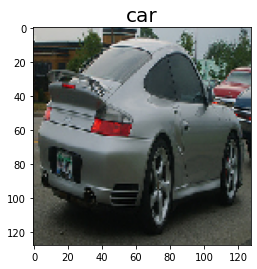

In [34]:
import matplotlib.pyplot as plt

plt.imshow(Xbatch[0])
plt.title(['other', 'car'][int(Ybatch[0])], fontsize = 20)
plt.show()



In [35]:
from keras import models
from keras import layers
from keras import callbacks


def make_convnet(batch_normalization = False, max_pool = True, dropout = 0.2, conv_filters = (32, 64), dense = (128, 32)):

    model = models.Sequential()

    for f in conv_filters:
        model.add(layers.Conv2D(filters = f, kernel_size = (4, 4), strides = (2,2), input_shape = (img_size, img_size, 3)))

        if batch_normalization:
            model.add(layers.BatchNormalization())
        if max_pool:
            model.add(layers.MaxPool2D(pool_size=(2,2)))    

    model.add(layers.Flatten())
    model.add(layers.Dropout(rate=dropout))

    for d in dense:
        model.add(layers.Dense(d, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [36]:
model = make_convnet()

In [37]:
fit_history = model.fit(train_generator, verbose=True, validation_data=test_generator, epochs = 6, callbacks=[callbacks.EarlyStopping(patience=2)])

Epoch 1/6
50/50 [==============================] - 15s 288ms/step - loss: 0.6172 - accuracy: 0.6606 - val_loss: 0.5972 - val_accuracy: 0.7066
Epoch 2/6
50/50 [==============================] - 14s 276ms/step - loss: 0.5181 - accuracy: 0.7544 - val_loss: 0.5973 - val_accuracy: 0.6979
Epoch 3/6
50/50 [==============================] - 14s 282ms/step - loss: 0.4720 - accuracy: 0.7850 - val_loss: 0.5215 - val_accuracy: 0.7622
Epoch 4/6
50/50 [==============================] - 15s 293ms/step - loss: 0.4343 - accuracy: 0.8031 - val_loss: 0.5100 - val_accuracy: 0.7708
Epoch 5/6
50/50 [==============================] - 13s 255ms/step - loss: 0.3558 - accuracy: 0.8475 - val_loss: 0.4897 - val_accuracy: 0.7726
Epoch 6/6
50/50 [==============================] - 12s 237ms/step - loss: 0.2726 - accuracy: 0.8844 - val_loss: 0.6073 - val_accuracy: 0.7517


|Batch normalization|Max pooling|Drop out rate|Conv filters |Dense layers|Final training accuracy %|Final validation accuracy %|Note|
|:--:|:--:|:--:|:-----:|:----:|:------------------------:|:---------------------:|:--:|
|T|T|0.2|(32, 64)|(128, 32)|80|53|Huge overfitting|
|F|T|0.2|(32, 64)|(128, 32)|88|78| |
|T|F|0.2|(32, 64)|(128, 32)|98|69|Extreme overfitting|
|F|F|0.2|(32, 64)|(128, 32)|80|70| |
|F|T|0.4|(32, 64)|(128, 32)|85|77| |
|F|T|0.4|(32, 64, 128)|(128, 32)|81|67| |
|F|T|0.4|(32, 64)|(128, 32, 32)|84|78| |

### The cnn overfits easily

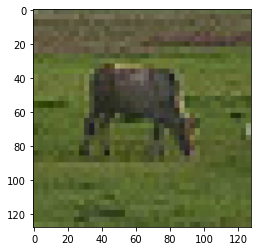

predicted: 'other' with certainty 95.27 % 
label: 'other'


In [38]:
n = random.randint(0, 31)

plt.imshow(Xbatch[n])
plt.show()

pred = model.predict(np.expand_dims(Xbatch[n], axis=0))[0][0]
pred_int = int(pred + 1/2)
certainty = pred if pred_int == 1 else 1 - pred
print("predicted:", ["'other'", "'car'"][pred_int], "with certainty", round(certainty*100,2),"%", "\nlabel:", ["'other'", "'car'"][int(Ybatch[n])])

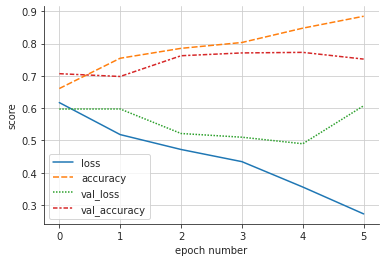

In [39]:
import seaborn as sns

sns.set_style("ticks")
sns.lineplot(data=fit_history.history)
sns.despine()
plt.grid()
plt.xlabel("epoch number")
plt.ylabel("score")
plt.show()

#### The convolutional neural network shows obvious signs of overfitting. The training accuracy increases, but the validation accuracy flattens

## Part 2 - augmented training data

In [40]:
augment_data_gen = ImageDataGenerator(rescale=1.0/255, rotation_range=45, horizontal_flip=True, vertical_flip=False, channel_shift_range=100, zoom_range=0.2)

augmented_train_gen = augment_data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True,
        )

Found 1600 images belonging to 2 classes.


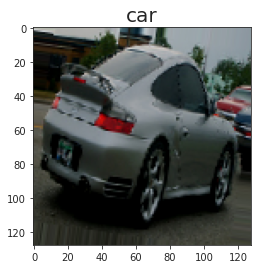

In [41]:
Xbatch, Ybatch = augmented_train_gen.next()
plt.imshow(Xbatch[0])
plt.title(['other', 'car'][int(Ybatch[0])], fontsize = 20)
plt.show()


In [42]:
model2 = make_convnet()
mod2_history = model2.fit(train_generator, verbose=True, validation_data=test_generator, epochs = 6)

Epoch 1/6
50/50 [==============================] - 12s 234ms/step - loss: 0.6522 - accuracy: 0.6087 - val_loss: 0.5984 - val_accuracy: 0.6997
Epoch 2/6
50/50 [==============================] - 11s 229ms/step - loss: 0.5266 - accuracy: 0.7538 - val_loss: 0.5399 - val_accuracy: 0.7448
Epoch 3/6
50/50 [==============================] - 11s 227ms/step - loss: 0.4616 - accuracy: 0.7862 - val_loss: 0.5130 - val_accuracy: 0.7656
Epoch 4/6
50/50 [==============================] - 11s 224ms/step - loss: 0.4012 - accuracy: 0.8269 - val_loss: 0.5424 - val_accuracy: 0.7795
Epoch 5/6
50/50 [==============================] - 12s 231ms/step - loss: 0.3498 - accuracy: 0.8469 - val_loss: 0.6180 - val_accuracy: 0.7031
Epoch 6/6
50/50 [==============================] - 11s 228ms/step - loss: 0.2911 - accuracy: 0.8775 - val_loss: 0.5315 - val_accuracy: 0.7431


In [43]:
model2.evaluate(test_generator)

18/18 [==============================] - 3s 163ms/step - loss: 0.5315 - accuracy: 0.7431


[0.5315250754356384, 0.7430555820465088]

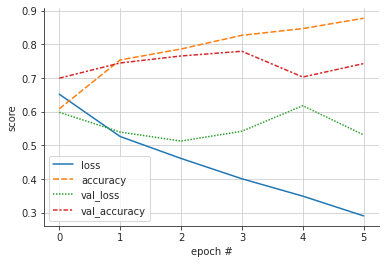

In [44]:
sns.set_style("ticks")
sns.lineplot(data=mod2_history.history)
sns.despine()
plt.xlabel("epoch #")
plt.ylabel("score")
plt.grid()
plt.show()

### Not a huge difference from part 1. Still overfitting

## Part 3 - Using VGG-16 as a feature extractor

In [45]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

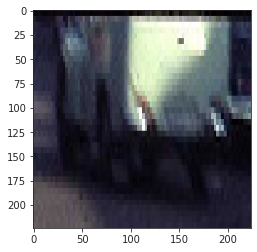

In [46]:
a = random.randint(0, train_generator.n - 1)

img = load_img(imgdir + "/train/" + train_generator.filenames[a], target_size=(224,224))

plt.imshow(img)
plt.show()


In [47]:
img_arr = img_to_array(img)
img_proc = preprocess_input(img_arr).reshape(1, 224, 224, 3)
prediction = vggmodel.predict(img_proc)
decode_predictions(prediction)

[[('n04501370', 'turnstile', 0.1858984),
  ('n04239074', 'sliding_door', 0.1235148),
  ('n04005630', 'prison', 0.10839594),
  ('n04404412', 'television', 0.08709626),
  ('n03529860', 'home_theater', 0.050528325)]]

#### Predictions are often not very good, but accurate in some cases. Maybe we have images of things not in the 1000 classes

In [48]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [49]:
def create_vgg16_features(dir, filename):
    data = vgg_data_gen.flow_from_directory(dir,
                                        target_size = (img_size, img_size),
                                        batch_size = batch_size,
                                        class_mode = 'binary',
                                        classes=['other', 'car'],                                    
                                        shuffle=False)

    cnn_features = feature_extractor.predict(data)
    with open(filename, 'wb') as f:
        np.save(f, cnn_features)


def train_on_cnnfeatures(testdir, train_features, test_features):
    
    with open(train_features, 'rb') as f:
        train_features = np.load(f)

    n = train_features.shape[0]
    train_labels = np.array([0]*(n//2) + [1]*(n//2))


    with open(test_features, 'rb') as f:
        test_features = np.load(f)

    n = test_features.shape[0]
    test_labels = np.array([0]*(n//2) + [1]*(n//2))

    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')        
    ])
    # model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

    model.fit(train_features, train_labels, verbose=True, validation_data=(test_features, test_labels), epochs = 6)
    return model


In [50]:
#Comment out these lines after 1st run to avoid extracting same features multiple times. (saves time)

create_vgg16_features(imgdir + "/train", "train_features.npy")
create_vgg16_features(imgdir + "/validation", "test_features.npy")

In [51]:
vgg_based_model = train_on_cnnfeatures(imgdir + "/validation", "train_features.npy", "test_features.npy")

Epoch 1/6
50/50 [==============================] - 1s 11ms/step - loss: 0.9702 - accuracy: 0.8669 - val_loss: 0.1534 - val_accuracy: 0.9392
Epoch 2/6
50/50 [==============================] - 0s 8ms/step - loss: 0.0894 - accuracy: 0.9731 - val_loss: 0.1916 - val_accuracy: 0.9323
Epoch 3/6
50/50 [==============================] - 0s 10ms/step - loss: 0.0423 - accuracy: 0.9850 - val_loss: 0.1891 - val_accuracy: 0.9462
Epoch 4/6
50/50 [==============================] - 1s 10ms/step - loss: 0.0167 - accuracy: 0.9950 - val_loss: 0.1826 - val_accuracy: 0.9427
Epoch 5/6
50/50 [==============================] - 0s 10ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.2088 - val_accuracy: 0.9427
Epoch 6/6
50/50 [==============================] - 0s 8ms/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 0.2149 - val_accuracy: 0.9514


#### A lot faster and more accurate than our CNN implementations. Some overfitting

## Part 4: Visualizing the learned features

In [52]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [53]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

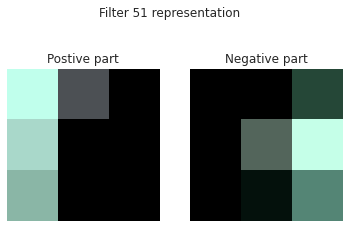

In [54]:
i = random.randint(0, first_layer_weights.shape[-1] -1)

plt.suptitle("Filter " + str(i) + " representation")
ker_img = kernel_image(first_layer_weights, i, True)
plt.subplot(1, 2, 1)
plt.imshow(ker_img)
plt.axis('off')
plt.title("Postive part")
ker_img = kernel_image(first_layer_weights, i, False)
plt.subplot(1, 2, 2)
plt.imshow(ker_img)
plt.title("Negative part")
plt.axis('off')
plt.show()

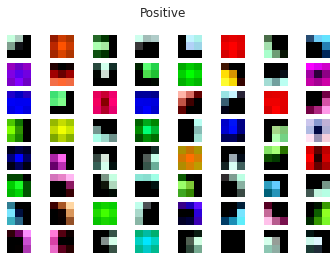

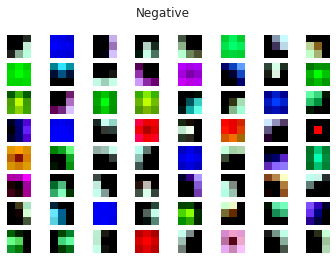

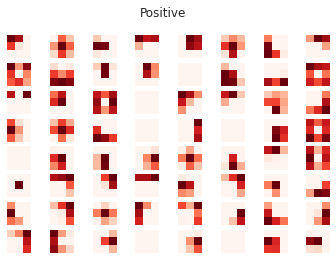

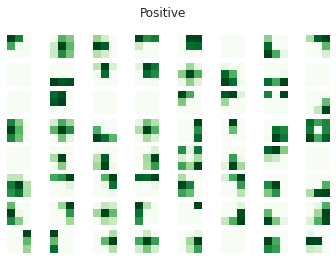

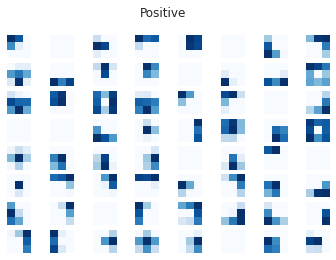

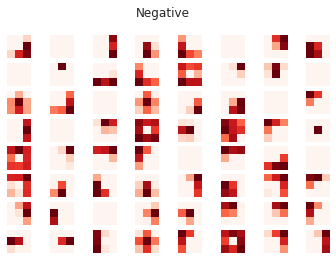

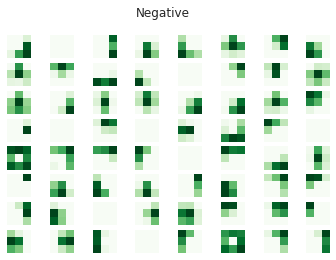

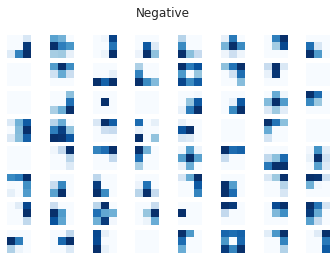

In [55]:
n = 64


plt.suptitle("Positive")
for i in range(0, n):
    plt.subplot(8, 8, i+1)
    ker_img = kernel_image(first_layer_weights, i, True)
    img = plt.imshow(ker_img)
    plt.axis('off')
plt.show()

plt.suptitle("Negative")
for i in range(0, n):
    plt.subplot(8, 8, i+1)
    ker_img = kernel_image(first_layer_weights, i, False)
    img = plt.imshow(ker_img)
    plt.axis('off')
plt.show()

plt.suptitle("Positive")
for i in range(0, n):
    plt.subplot(8, 8, i+1)
    ker_img = kernel_image(first_layer_weights, i, True)
    img = plt.imshow(ker_img[:, :, 0], cmap='Reds')
    plt.axis('off')
plt.show()

plt.suptitle("Positive")
for i in range(0, n):
    plt.subplot(8, 8, i+1)
    ker_img = kernel_image(first_layer_weights, i, True)
    img = plt.imshow(ker_img[:, :, 1], cmap='Greens')
    plt.axis('off')
plt.show()

plt.suptitle("Positive")
for i in range(0, n):
    plt.subplot(8, 8, i+1)
    ker_img = kernel_image(first_layer_weights, i, True)
    img = plt.imshow(ker_img[:, :, 2], cmap='Blues')
    plt.axis('off')
plt.show()

plt.suptitle("Negative")
for i in range(0, n):
    plt.subplot(8, 8, i+1)
    ker_img = kernel_image(first_layer_weights, i, False)
    img = plt.imshow(ker_img[:, :, 0], cmap = 'Reds')
    plt.axis('off')
plt.show()

plt.suptitle("Negative")
for i in range(0, n):
    plt.subplot(8, 8, i+1)
    ker_img = kernel_image(first_layer_weights, i, False)
    img = plt.imshow(ker_img[:, :, 1], cmap = 'Greens')
    plt.axis('off')
plt.show()

plt.suptitle("Negative")
for i in range(0, n):
    plt.subplot(8, 8, i+1)
    ker_img = kernel_image(first_layer_weights, i, False)
    img = plt.imshow(ker_img[:, :, 2], cmap = 'Blues')
    plt.axis('off')
plt.show()

### The above images visualize what each filter award and punish, also decomposed for each channel. They are all logical geomtrical figures and shapes. Clearly some kind of edge finding

In [56]:
own_weights = model2.get_weights()[0]
own_weights.shape

(4, 4, 3, 32)

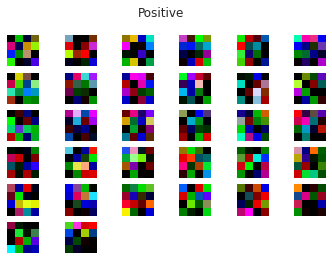

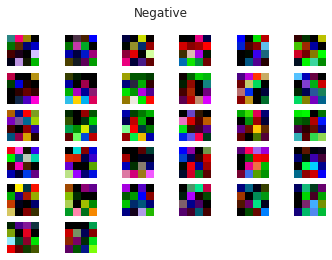

In [57]:
n = own_weights.shape[-1]

plt.suptitle("Positive")
for i in range(0, n):
    plt.subplot(6, 6, i+1)
    ker_img = kernel_image(own_weights, i, True)
    img = plt.imshow(ker_img[:, :, :], cmap = 'Reds')
    plt.axis('off')
plt.show()

plt.suptitle("Negative")
for i in range(0, n):
    plt.subplot(6, 6, i+1)
    ker_img = kernel_image(own_weights, i, False)
    img = plt.imshow(ker_img[:, :, :], cmap = 'Reds')    
    plt.axis('off')
plt.show()

### The same experiment done on own CNN yields a much less interpretable pattern. Why does this identify cars 80% of the time? Not easy to say

### Below follows the activation of each of the above filters from our CNN on a car image. The first layer highlights some edges and key-features of a car. The deeper layers are less interpretable

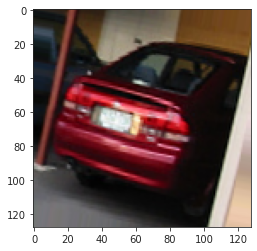

(1, 63, 63, 32)


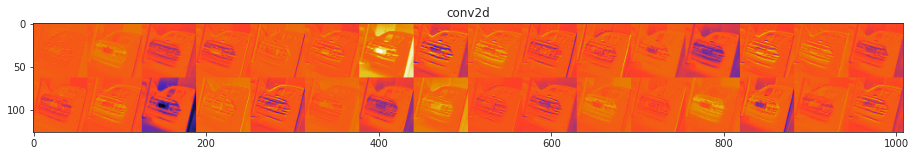

(1, 31, 31, 32)


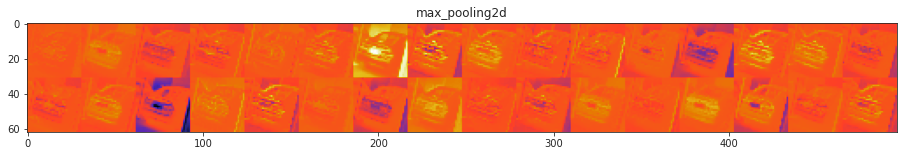

(1, 14, 14, 64)


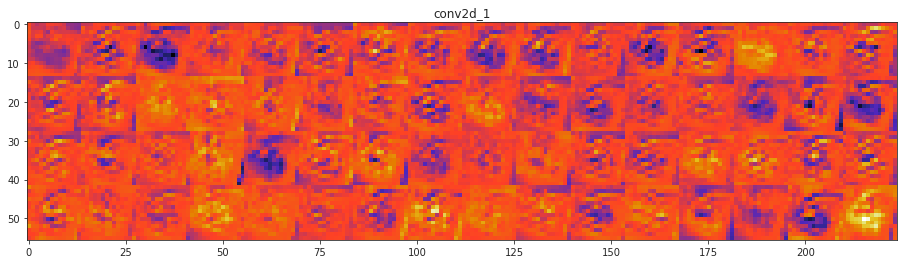

(1, 7, 7, 64)


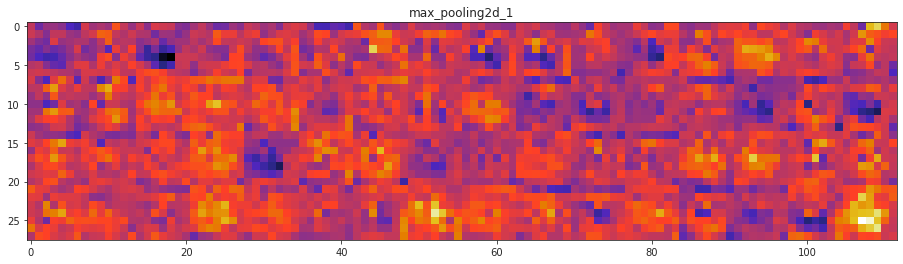

In [58]:
img = Xbatch[1]

plt.imshow(img)
plt.show()

###Code below is adapted from https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md#visualizing-every-channel-in-every-intermediate-activation

layer_outputs = [layer.output for layer in model2.layers[:4]] # Extracts the outputs of the top 4 layers
activation_model = keras.models.Model(inputs=model2.input, outputs=layer_outputs)
activations = activation_model(np.expand_dims(img, axis=0)) # Returns a list of five Numpy arrays: one array per layer activation

layer_names = [layer.name for layer in model.layers[:4]] # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    print(layer_activation.shape)
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, cmap='CMRmap')
    plt.show()

### The same experiment for the VGG-model. Here even the deeper layers make sense. Clear edge detection

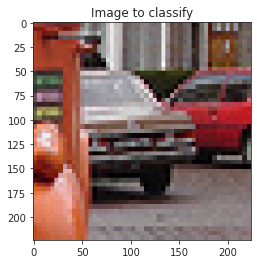

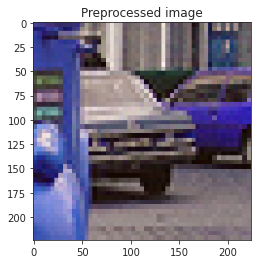

Classified as: [('n04443257', 'tobacco_shop', 0.34457788), ('n03661043', 'library', 0.2864751), ('n02871525', 'bookshop', 0.08780457), ('n03095699', 'container_ship', 0.030249087), ('n02870880', 'bookcase', 0.01426781)]


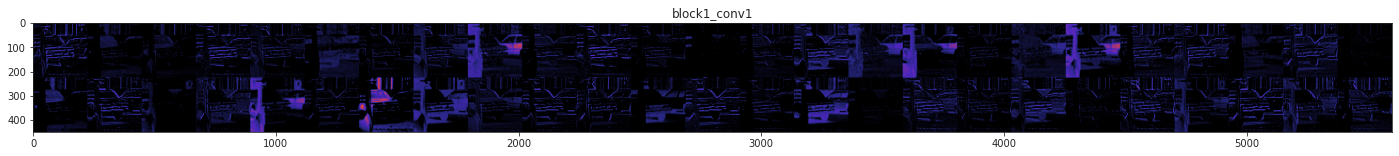

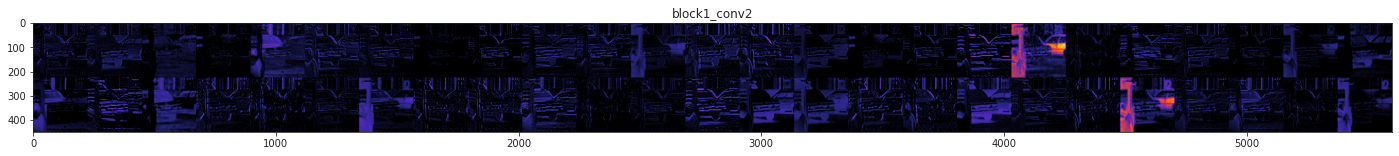

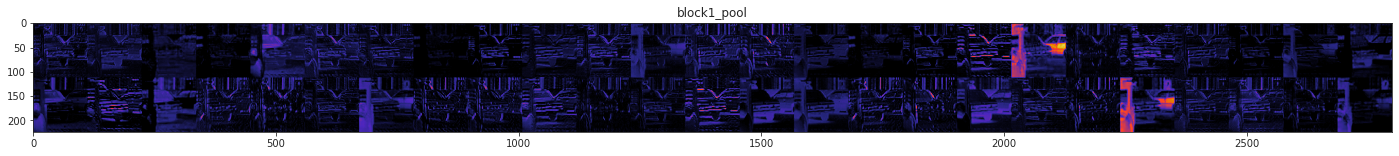

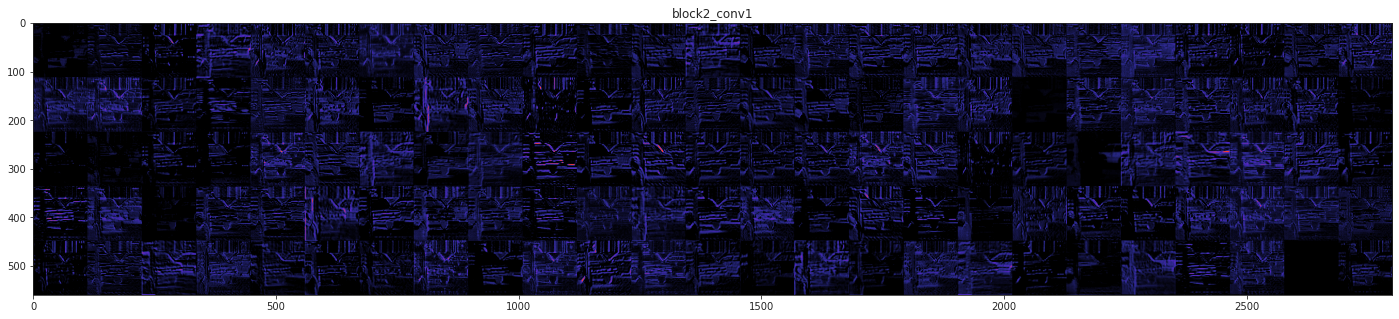

In [59]:
a = random.randint(0, train_generator.n-1)

img = load_img(imgdir + "/train/" + train_generator.filenames[a], target_size=(224,224))
plt.imshow(img)
plt.title("Image to classify")
plt.show()
img = preprocess_input(img_to_array(img))

img2 = (img - img.min()) /(img.max() - img.min()) #make the preprocessed image viewable aka pixel values in [0,1)

plt.imshow(img2)
plt.title("Preprocessed image")
plt.show()

img = img.reshape(1, 224, 224, 3)
prediction = vggmodel.predict(img)
print("Classified as:", decode_predictions(prediction)[0])
###Code below is adapted from https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md#visualizing-every-channel-in-every-intermediate-activation

layer_outputs = [layer.output for layer in vggmodel.layers[1:5]] # Extracts the outputs of the top 4 layers
activation_model = keras.models.Model(inputs=vggmodel.input, outputs=layer_outputs)
activations = activation_model(img) # Returns a list of five Numpy arrays: one array per layer activation

layer_names = [layer.name for layer in vggmodel.layers[1:5]] # Names of the layers, so you can have them as part of your plot
    
images_per_row = 25

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, cmap="CMRmap")
    plt.show()